In [1]:
from typing import List, Mapping
from itertools import zip_longest, chain
from glob import iglob
from pickle import load
from functools import partial, reduce

from scipy.ndimage.filters import gaussian_filter
import pandas as pd
import numpy as np
from numpy.random import normal, choice, rand
from numpy.polynomial.legendre import Legendre
import matplotlib.pyplot as plt
from h5py import File

from vmitools import (
    abel_inverse, finite_legendre_transform_in_theta,
    interp, tohist, transpose_linearly, transpose_to_drdomega, transpose_to_drdth,
    mrot, mhorshear, msqueeze,
)

In [2]:
runs = range(307, 316+1)
filenames = sorted(chain.from_iterable(iglob(f"/data/*/Run_{r:03d}/work/reduced.pickle") for r in runs if not r in {}))
print(f"Total {len(filenames)} files:")
for fn in filenames:
    print(f"    {fn}")

Total 10 files:
    /data/Step601N2/Run_307/work/reduced.pickle
    /data/Step601N2/Run_308/work/reduced.pickle
    /data/Step601N2/Run_309/work/reduced.pickle
    /data/Step601N2/Run_310/work/reduced.pickle
    /data/Step601N2/Run_311/work/reduced.pickle
    /data/Step601N2/Run_312/work/reduced.pickle
    /data/Step601N2/Run_313/work/reduced.pickle
    /data/Step601N2/Run_314/work/reduced.pickle
    /data/Step601N2/Run_315/work/reduced.pickle
    /data/Step601N2/Run_316/work/reduced.pickle


In [3]:
def read_file(filename):
    with open(filename, 'br') as f:
        return load(f)


sumup = partial(reduce, partial(pd.DataFrame.add, fill_value=0))
summed = sumup(read_file(fn) for fn in filenames)
summed

sum    count
is_bg delay atmax                                                            
False -6.82 515    [[111.0, 94.0, 103.0, 105.0, 109.0, 106.0, 102...      1.0
            530    [[107.0, 104.0, 104.0, 113.0, 104.0, 103.0, 98...      1.0
            535    [[631.0, 642.0, 624.0, 622.0, 624.0, 612.0, 60...      6.0
            540    [[4435.0, 4322.0, 4364.0, 4407.0, 4423.0, 4353...     42.0
            545    [[18018.0, 17742.0, 17888.0, 18018.0, 18178.0,...    171.0
            550    [[139569.0, 138023.0, 138564.0, 140301.0, 1409...   1329.0
            555    [[1134904.0, 1122055.0, 1128247.0, 1141118.0, ...  10892.0
            560    [[2297351.0, 2267415.0, 2283910.0, 2308319.0, ...  22077.0
            565    [[3367674.0, 3332241.0, 3344805.0, 3384037.0, ...  32166.0
            570    [[4580553.0, 4536080.0, 4549563.0, 4605896.0, ...  43588.0
            575    [[4312029.0, 4267318.0, 4282911.0, 4335586.0, ...  41105.0
            580    [[3092866.0, 3059804.0, 3073930.0, 3108508.0, ...  29653.0
            585    [[325863.0, 322080.0, 324210.0, 327122.0, 3288...   3126.0
            590    [[54053.0, 53469.0, 53797.0, 54298.0, 54582.0,...    518.0
            595    [[521.0, 536.0, 512.0, 513.0, 520.0, 513.0, 53...      5.0
True  -6.82 535    [[205.0, 188.0, 198.0, 214.0, 201.0, 203.0, 18...      2.0
            540    [[2480.0, 2464.0, 2449.0, 2460.0, 2518.0, 2483...     24.0
            545    [[9966.0, 9808.0, 9953.0, 10013.0, 10037.0, 98...     96.0
            550    [[65694.0, 64595.0, 65251.0, 65915.0, 66228.0,...    632.0
            555    [[563529.0, 556702.0, 561047.0, 565923.0, 5687...   5443.0
            560    [[1159081.0, 1142366.0, 1152286.0, 1162539.0, ...  11193.0
            565    [[1660357.0, 1637951.0, 1650768.0, 1666018.0, ...  16023.0
            570    [[2250054.0, 2218403.0, 2237625.0, 2258165.0, ...  21742.0
            575    [[2124302.0, 2093872.0, 2112212.0, 2130448.0, ...  20523.0
            580    [[1539060.0, 1517733.0, 1531472.0, 1545032.0, ...  14873.0
            585    [[166046.0, 164197.0, 165160.0, 166621.0, 1674...   1602.0
            590    [[25792.0, 25652.0, 25714.0, 25826.0, 26024.0,...    249.0
            595    [[207.0, 210.0, 207.0, 203.0, 216.0, 206.0, 21...      2.0

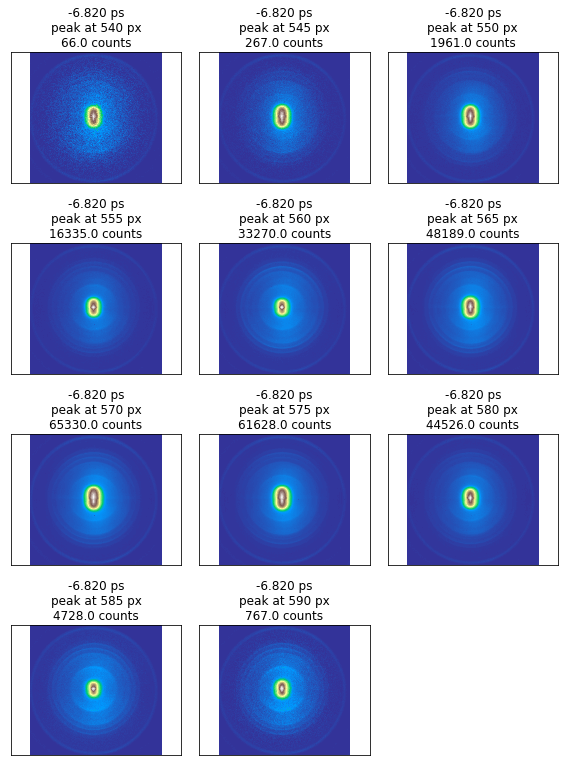

In [4]:
def good_img(img):
    return not np.isnan(img).any()


n = summed['count'].loc[False] + summed['count'].loc[True]
avg = summed['sum'] / summed['count']
diff = (avg.loc[False] - avg.loc[True])
where = (50 < n) & (diff.apply(good_img))
df = pd.DataFrame({
    'img': diff[where].apply(partial(np.einsum, 'ij->ji')),
    'n': n[where],
})

plt.figure(figsize=(8, 16))
for i, ((dt, atmax), img, n) in enumerate(df[['img', 'n']].itertuples()):
    plt.subplot(6, 3, i+1)
    plt.title(f"{dt:.3f} ps\npeak at {atmax} px\n{n} counts")
    plt.pcolormesh(img.T, cmap='terrain')
    plt.axis("equal")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.clim(0, None)
plt.tight_layout()
plt.show()

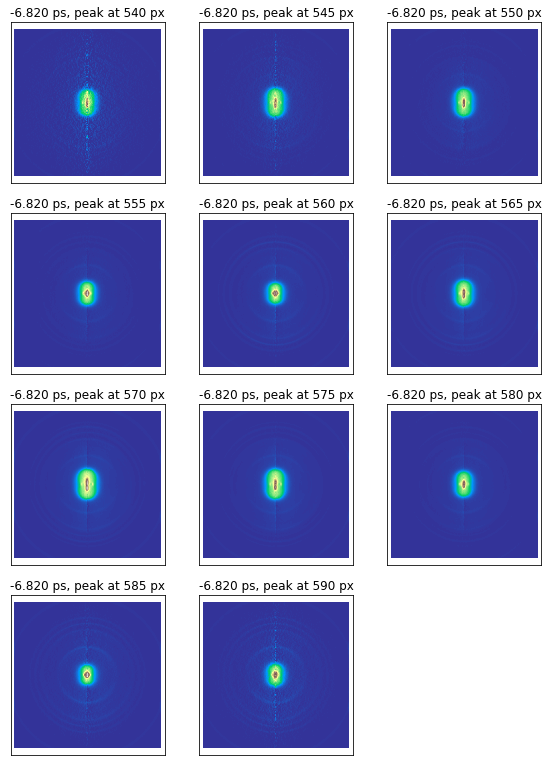

In [5]:
zedges = np.arange(-400, 400 + 1)
redges, thedges = np.linspace(0, 400, 400 + 1), np.linspace(-np.pi, np.pi, 360 + 1)
r = (redges[1:] + redges[:-1]) / 2
th = (thedges[1:] + thedges[:-1]) / 2


def invert_img(d):
    img = d['img']
    img = gaussian_filter(img, 2)
    xn, yn = img.shape
    xedges = np.arange(xn + 1)
    yedges = np.arange(yn + 1)
    f = interp(img, xedges, yedges)
    g = transpose_linearly(f, np.eye(2), x0=np.array([437, 458]))
    transformed = tohist(g, zedges, zedges)

    dz = zedges[1:] - zedges[:-1]
    inverted = abel_inverse(transformed, zedges) * dz[None, :]  # shape: (r, z)
    sliced = interp(inverted, zedges, zedges)  # (rho, z) -> intensity
    hist_indrdomega = tohist(transpose_to_drdomega(sliced), redges, thedges)  # (r, th) -> intensity
    hist_indrdth = tohist(transpose_to_drdth(sliced), redges, thedges)  # (r, th) -> intensity
    return pd.Series({
        'inverted': inverted,
        'hist_indrdth': hist_indrdth,
        'hist_indrdomega': hist_indrdomega,
    })


df = df.merge(df.apply(invert_img, axis=1), left_index=True, right_index=True)


plt.figure(figsize=(8, 16))
for i, ((dt, atmax), img, n) in enumerate(df[['inverted', 'n']].itertuples()):
    plt.subplot(6, 3, i+1)
    plt.title(f"{dt:.3f} ps, peak at {atmax} px")
    plt.pcolormesh(img.T, cmap='terrain')
    plt.axis("equal")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.clim(0, None)
plt.tight_layout()
plt.show()

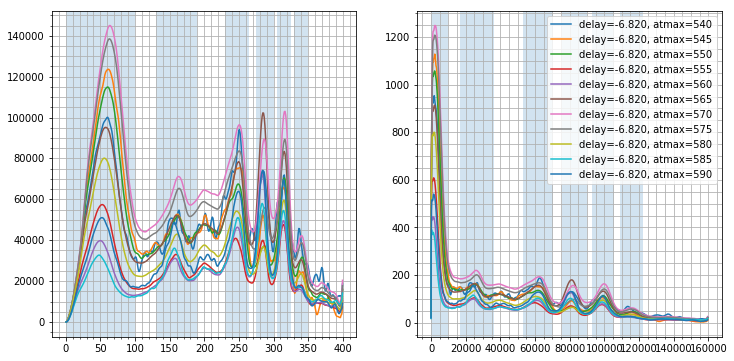

In [6]:
roi = [
    [0, 100],
    [130, 190],
    [230, 265],
    [275, 300],
    [305, 325],
    [330, 350],
]


def f(hist):
    return hist.sum(1)


def intergrateit(hist, fr, to, x=None, **kwargs):
    if x is None:
        x = np.arange(len(hist))
    where = (fr < x) & (x < to)
    return hist[where].sum(**kwargs)


def project_to_pn(hist, n):
    _, coeff, _ = finite_legendre_transform_in_theta(
        hist, thedges, n + 1,
    )  # Shapes of returns: (n, r) (n, r) (n, th)
    return coeff[n]/coeff[0]


for i, (fr, to) in enumerate(roi):
    df[f'summed{i}_rdist'] = df['hist_indrdth'].apply(intergrateit, fr=fr, to=to, x=r)
    df[f'summed{i}_pad'] = df['hist_indrdomega'].apply(intergrateit, fr=fr, to=to, x=r, axis=0)
    df[f'summed{i}_beta2'] = df[f'summed{i}_pad'].apply(project_to_pn, n=2)
    df[f'summed{i}_beta4'] = df[f'summed{i}_pad'].apply(project_to_pn, n=4)


plt.figure(figsize=(12, 6))
plt.subplot(121)
for (dt, atmax), dist in df['hist_indrdth'].apply(f).items():
    plt.plot(r, dist, label=f"delay={dt:.3f},atmax={atmax}")
plt.minorticks_on()
plt.grid(True, which='both')

for fr, to in roi:
    plt.axvspan(fr, to, alpha=0.2)

plt.subplot(122)
for (dt, atmax), dist in df['hist_indrdth'].apply(f).items():
    plt.plot(r**2, dist/2/r, label=f"delay={dt:.3f}, atmax={atmax}")
plt.minorticks_on()
plt.grid(True, which='both')

for fr, to in roi:
    plt.axvspan(fr**2, to**2, alpha=0.2)

plt.legend()
plt.show()

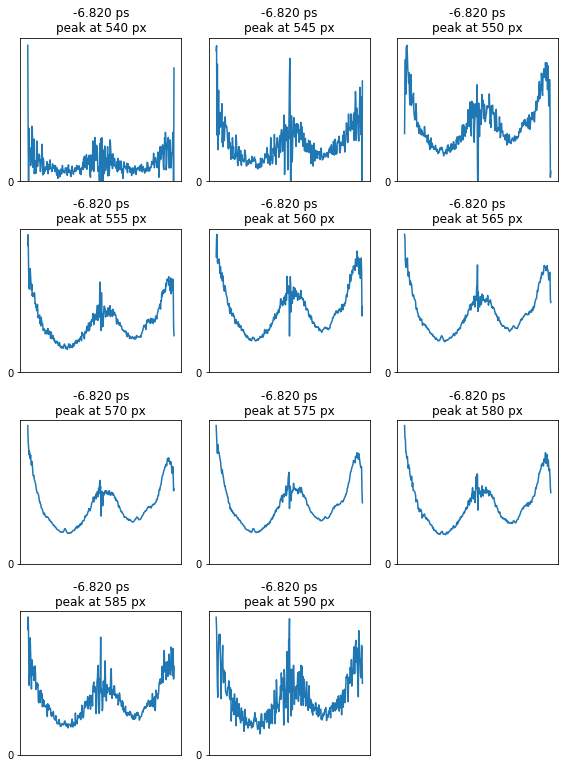

In [7]:
plt.figure(figsize=(8, 16))
for i, ((dt, atmax), pad) in enumerate(df['summed2_pad'].items()):
    plt.subplot(6, 3, i+1)
    plt.title(f"{dt:.3f} ps\npeak at {atmax} px")
    plt.plot(th, pad)
    plt.xticks([], [])
    plt.yticks([0], [0])
    plt.ylim(0, None)
plt.tight_layout()
plt.show()

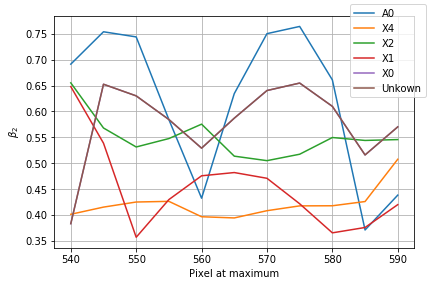

In [8]:
at = df.index[0][0]


def norm(arr):
    return arr/arr.sum()


plt.figure()
plt.xlabel("Pixel at maximum")
plt.ylabel(r"$\beta_2$")
plt.plot(df.loc[at]['summed0_beta2'], label='A0')
plt.plot(df.loc[at]['summed1_beta2'], label='X4')
plt.plot(df.loc[at]['summed2_beta2'], label='X2')
plt.plot(df.loc[at]['summed3_beta2'], label='X1')
plt.plot(df.loc[at]['summed4_beta2'], label='X0')
plt.plot(df.loc[at]['summed4_beta2'], label='Unkown')
# plt.ylim(0, None)
plt.grid(True)
plt.figlegend()
plt.tight_layout()
plt.show()

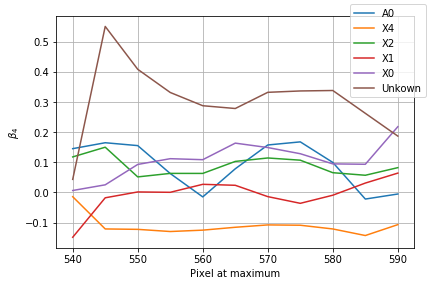

In [9]:
at = df.index[0][0]


def norm(arr):
    return arr/arr.sum()


plt.figure()
plt.xlabel("Pixel at maximum")
plt.ylabel(r"$\beta_4$")
plt.plot(df.loc[at]['summed0_beta4'], label='A0')
plt.plot(df.loc[at]['summed1_beta4'], label='X4')
plt.plot(df.loc[at]['summed2_beta4'], label='X2')
plt.plot(df.loc[at]['summed3_beta4'], label='X1')
plt.plot(df.loc[at]['summed4_beta4'], label='X0')
plt.plot(df.loc[at]['summed5_beta4'], label='Unkown')
# plt.ylim(0, None)
plt.grid(True)
plt.figlegend()
plt.tight_layout()
plt.show()

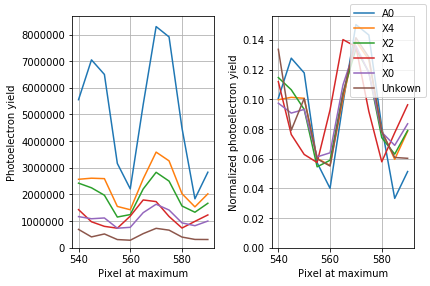

In [10]:
at = df.index[0][0]


def norm(arr):
    return arr/arr.sum()


plt.figure()
plt.subplot(121)
plt.xlabel("Pixel at maximum")
plt.ylabel("Photoelectron yield")
plt.plot(df.loc[at]['summed0_rdist'], label='A0')
plt.plot(df.loc[at]['summed1_rdist'], label='X4')
plt.plot(df.loc[at]['summed2_rdist'], label='X2')
plt.plot(df.loc[at]['summed3_rdist'], label='X1')
plt.plot(df.loc[at]['summed4_rdist'], label='X0')
plt.plot(df.loc[at]['summed5_rdist'], label='Unkown')
plt.ylim(0, None)
plt.grid(True)
plt.figlegend()

plt.subplot(122)
plt.xlabel("Pixel at maximum")
plt.ylabel("Normalized photoelectron yield")
plt.plot(norm(df.loc[at]['summed0_rdist']), label='A0')
plt.plot(norm(df.loc[at]['summed1_rdist']), label='X4')
plt.plot(norm(df.loc[at]['summed2_rdist']), label='X2')
plt.plot(norm(df.loc[at]['summed3_rdist']), label='X1')
plt.plot(norm(df.loc[at]['summed4_rdist']), label='X0')
plt.plot(norm(df.loc[at]['summed5_rdist']), label='Unkown')
plt.ylim(0, None)
plt.grid(True)
# plt.figlegend()
plt.tight_layout()
plt.show()